In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.api import qqplot

In [4]:
# Read csv and set delimiter to ';'.
df = pd.read_csv("data/smhi-lufttemperatur.csv", sep=";")

In [5]:
df

,Datum,Tid (UTC),Lufttemperatur,Kvalitet
0,2010-03-01,00:00:00,2.0,G
1,2010-03-01,01:00:00,2.2,Y
2,2010-03-01,02:00:00,2.2,Y
3,2010-03-01,03:00:00,1.7,G
4,2010-03-01,04:00:00,1.7,Y
...,...,...,...,...
108214,2022-08-01,02:00:00,16.2,G
108215,2022-08-01,03:00:00,16.0,G
108216,2022-08-01,04:00:00,16.1,G
108217,2022-08-01,05:00:00,17.4,G


### Data preprocessing

In [6]:
def transform(df_: pd.DataFrame, col: str, new_name: str, dtype=np.int8) -> pd.DataFrame:
    """
    Description:
      Transform a pandas dataframe in the following way:
      1. Creates a datetime column (ds); concatenating the date-column (YYYY-MM-DD) with UTC time column.
      2. Renames the air temperature column so that it is compatible with the interface to facebook prophets API.
      3. Removes all observations that have a quality other than 'G'.
      4. Subsets for the datetime (ds) and air temperature (y) column.
      5. Sizes down air temperature (y) to an 8bit integer

    Args:
      df_ (pandas dataframe): Pandas dataframe to transform.

    Returns:
      Transformed dataframe.
    """
    return (df_
        .assign(ds=pd.to_datetime(df_["Datum"] + " " + df_["Tid (UTC)"]))
        .rename(columns={col: new_name})
        .query("Kvalitet != 'Y'")
        .loc[:, ("ds", new_name)] # type: ignore
        .astype({new_name: dtype}))

In [55]:
# Create dataframe for each regressor.
precip = transform(pd.read_csv("data/nederbördsmängd.csv", sep=";"), "Nederbördsmängd", "precipitation_amount", np.float16)
pressure = transform(pd.read_csv("data/smhi-luftryck.csv", sep=";"), "Lufttryck", "air_pressurse", np.float32)
humid = transform(pd.read_csv("data/smhi-luftfuktighet.csv", sep=";"), "Luftfuktighet", "air humidity")
cloud = transform(pd.read_csv("data/smhi-molnmängd.csv", sep=";"), "Total molnmängd", "total_cloud_amount")
wind = transform(pd.read_csv("data/smhi-vind.csv", sep=";").dropna(), "Vindhastighet", "wind_speed")

In [51]:
# Unified dataframe with all regressors.
regressors = (precip
    .merge(pressure, on="ds", how="inner")
    .merge(humid, on="ds", how="inner")
    .merge(cloud, on="ds", how="inner")
    .merge(wind, on="ds", how="inner"))

In [54]:
regressors

,ds,precipitation_amount,air_pressurse,air humidity,total_cloud_amount,wind_speed
0,2014-10-18 22:00:00,0.0,1018.500000,97,100,9
1,2014-10-18 23:00:00,0.0,1017.799988,97,100,10
2,2014-10-19 01:00:00,0.0,1016.099976,97,100,9
3,2014-10-19 02:00:00,0.0,1014.900024,96,100,9
4,2014-10-19 03:00:00,0.0,1013.900024,96,100,8
...,...,...,...,...,...,...
32875,2019-10-14 04:00:00,0.0,1003.799988,88,0,11
32876,2019-10-14 05:00:00,0.0,1004.000000,82,0,12
32877,2019-10-14 07:00:00,0.0,1004.900024,83,0,11
32878,2019-10-14 08:00:00,0.0,1005.099976,79,0,14


In [56]:
# Function call to transform.
weather = transform(df, "Lufttemperatur", "y")

In [57]:
weather

,ds,y
0,2010-03-01 00:00:00,2
3,2010-03-01 03:00:00,1
6,2010-03-01 06:00:00,1
9,2010-03-01 09:00:00,1
12,2010-03-01 12:00:00,1
...,...,...
108214,2022-08-01 02:00:00,16
108215,2022-08-01 03:00:00,16
108216,2022-08-01 04:00:00,16
108217,2022-08-01 05:00:00,17


In [58]:
# Earliest/latest observation and lowest/highest recorded temperature.
weather.min(), weather.max()

(ds    2010-03-01 00:00:00
 y                     -14
 dtype: object,
 ds    2022-08-01 06:00:00
 y                      30
 dtype: object)

In [59]:
# Number of null-values.
weather.isna().sum()

ds    0
y     0
dtype: int64

### Data exploration

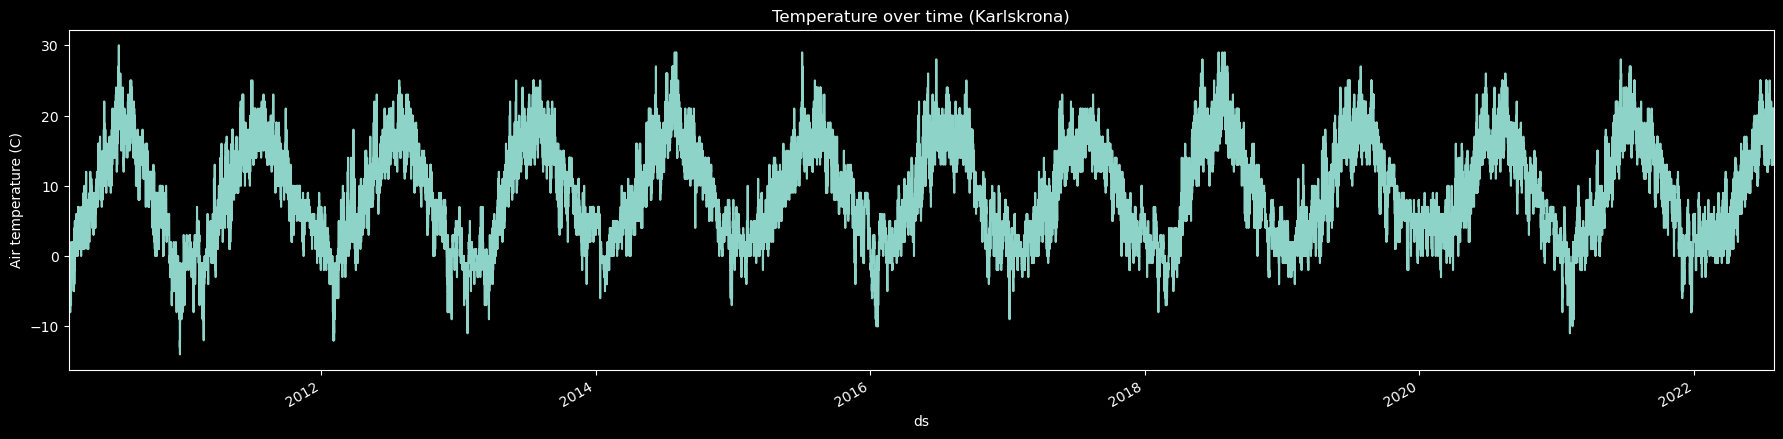

In [60]:
# Figure of air temperature over time.
(weather
 .plot(
     x="ds",
     y="y",
     title="Temperature over time (Karlskrona)",
     label="Date", ylabel="Air temperature (C)",
     legend=None,
     figsize=(22, 5),
     xlim=(weather["ds"].min(), weather["ds"].max())));

**From the above plot we can see a seasonal pattern.**

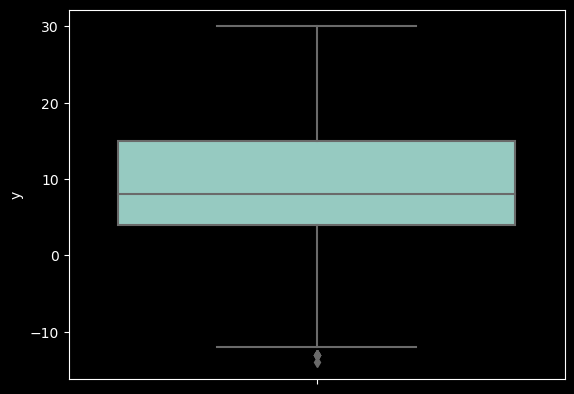

In [61]:
# Boxplot for outlier detection.
sns.boxplot(data=weather, y="y");

**We see very few values outside of the whiskers. Of these values, none seem overtly suspicious and we will therefore not remove them from the data set.**

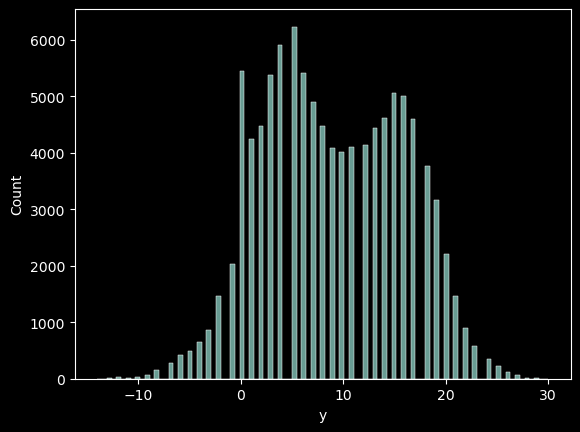

In [62]:
# Distribution plot of temperature.
sns.histplot(data=weather, x="y"); 

**The distribution seems bimodial.**

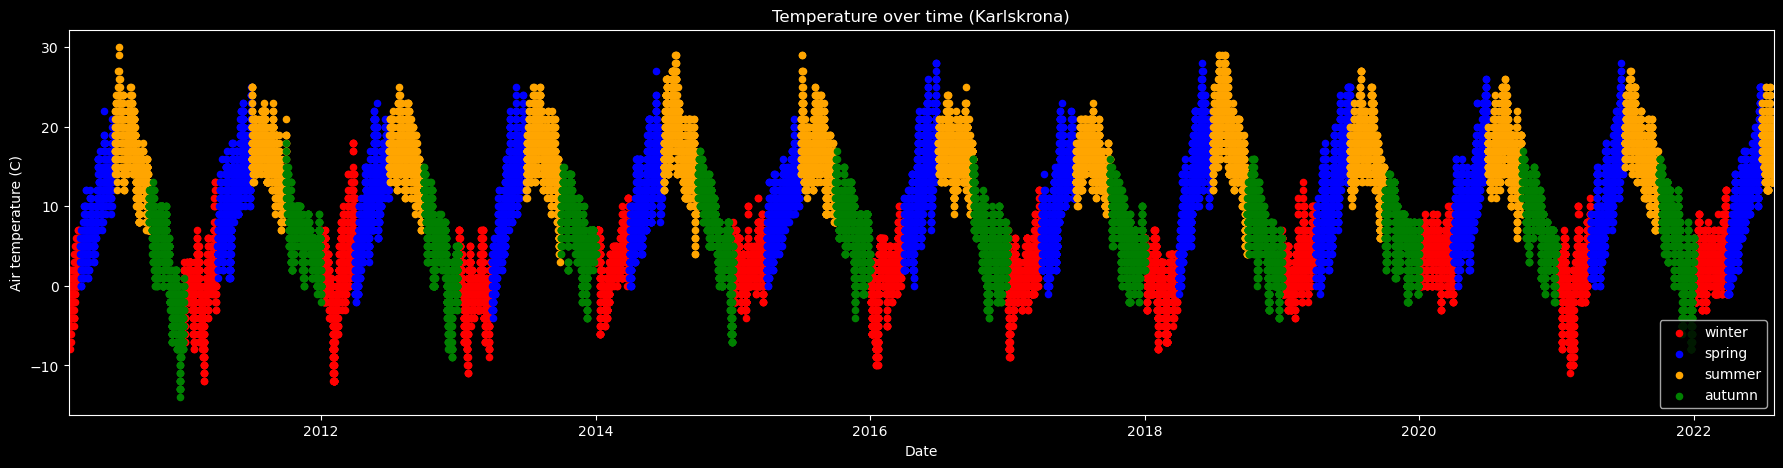

In [63]:
# Create a figure and axis object.
fig, ax = plt.subplots(figsize=(22, 5))

# Create a new feature: season.
temp = weather.assign(season=(((weather["ds"]).dt.month - 1) // 3))

# Map discrete values to their corresponding categories.
maping = {0: "winter", 1: "spring", 2: "summer", 3: "autumn"}
temp["season"] = temp.season.map(maping)

# Create plot and color according to season.
temp.query("season == 'winter'").plot(kind="scatter", x="ds", y="y", color="red", label="winter", ax=ax)
temp.query("season == 'spring'").plot(kind="scatter", x="ds", y="y", color="blue", label="spring", ax=ax)
temp.query("season == 'summer'").plot(kind="scatter", x="ds", y="y", color="orange", label="summer", ax=ax)
temp.query("season == 'autumn'").plot(kind="scatter", x="ds", y="y", color="green", label="autumn", ax=ax)

# Configure plot.
ax.set(xlabel="Date", ylabel="Air temperature (C)", title="Temperature over time (Karlskrona)", xlim=(temp["ds"].min(), temp["ds"].max()))

# Show plot.
plt.show()

### 1. Spliting

In [64]:
# Split data into training and testing (80/20 split).
train = weather[weather["ds"] < pd.Timestamp("2020-02-25")]
test = weather[weather["ds"] >= pd.Timestamp("2020-02-25")]

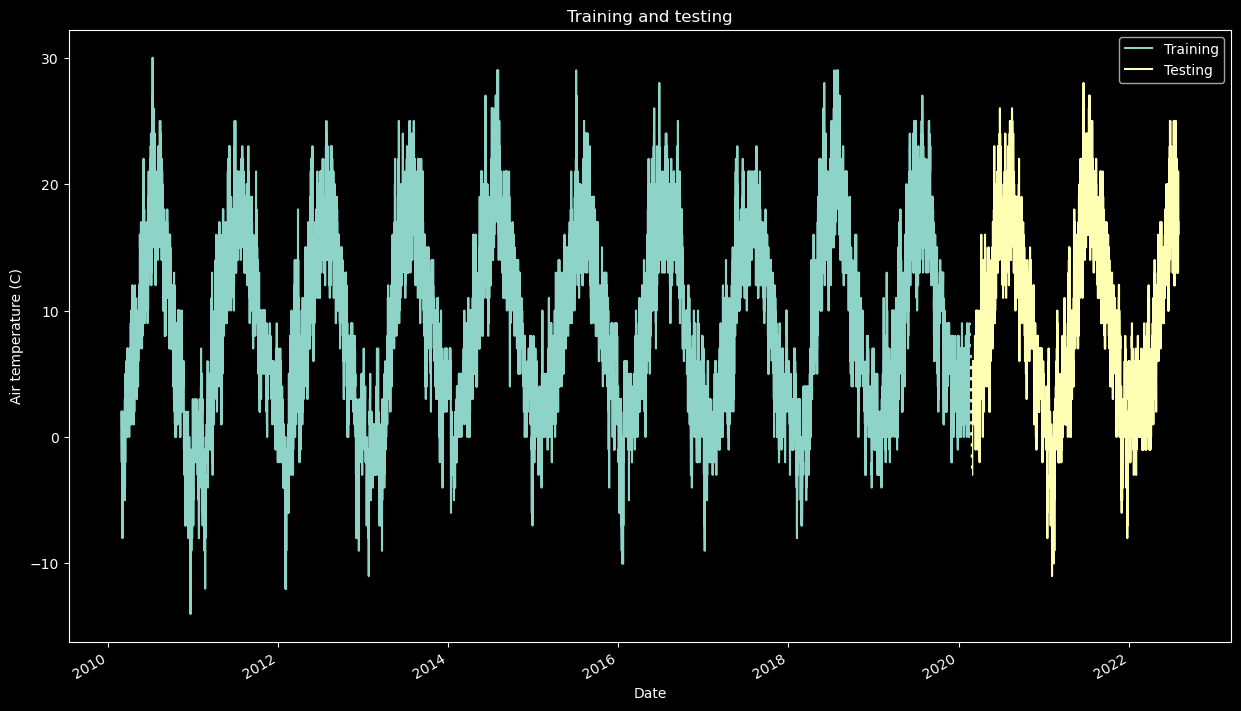

In [65]:
# Create a figure and axis object.
fig, ax = plt.subplots(figsize=(15, 9))

# Plot training and testing data.
train.plot(ax=ax, x="ds", y="y", label="Training")
test.plot(ax=ax, x="ds", y="y", label="Testing")

# Add a vertical line where training and testing split.
ax.axvline(test["ds"].min(), color="black", ls="--")

# Prettifying plot.
ax.set(title="Training and testing", xlabel="Date", ylabel="Air temperature (C)")

# Show plot.
plt.show()

### 2. Modeling

In [66]:
%%time

# Instantiate and train model.
m = Prophet()
m.fit(train);

NameError: name 'Prophet' is not defined

In [ ]:
%%time

# Instantiate and train model (with regressors).
m_regressors = Prophet()
m_regressors.fit(train);

In [151]:
# Create a dataframe with future dates we want to predict. We want the same dates as in our test set.
future = pd.DataFrame(test["ds"].values, columns=["ds"])

In [153]:
future

,ds
0,2020-02-25 00:00:00
1,2020-02-25 01:00:00
2,2020-02-25 02:00:00
3,2020-02-25 03:00:00
4,2020-02-25 04:00:00
...,...
21192,2022-08-01 02:00:00
21193,2022-08-01 03:00:00
21194,2022-08-01 04:00:00
21195,2022-08-01 05:00:00


In [52]:
# Forecasts on the dates in the future table.
forecast = m.predict(future)

In [ ]:
# Lower, middle and upper predictions on 2022-08-01 from 02:00 untill 06:00.
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
21192,2022-08-01 02:00:00,21.088114,-3.427502,43.818938
21193,2022-08-01 03:00:00,20.984804,-3.463325,43.435869
21194,2022-08-01 04:00:00,20.981610,-3.438637,43.848285
21195,2022-08-01 05:00:00,21.125689,-3.240443,44.774951
21196,2022-08-01 06:00:00,21.429622,-2.865396,44.332200


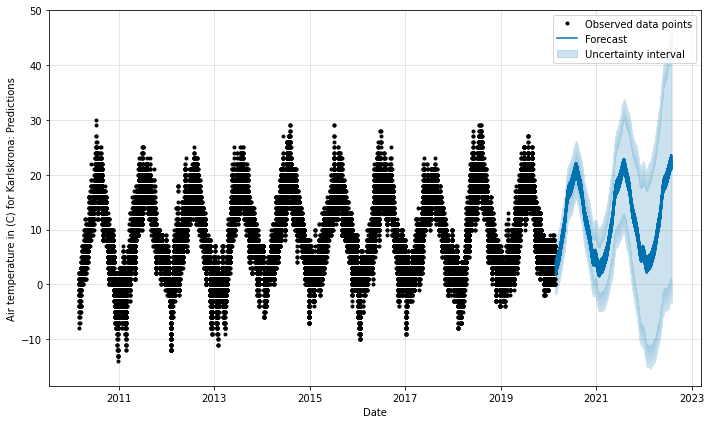

In [57]:
# Plot of our historical data and forecasts (with uncertainty intervals).
fsct_plot = m.plot(forecast, ylabel="Air temperature in (C)", xlabel="Date", include_legend=True)

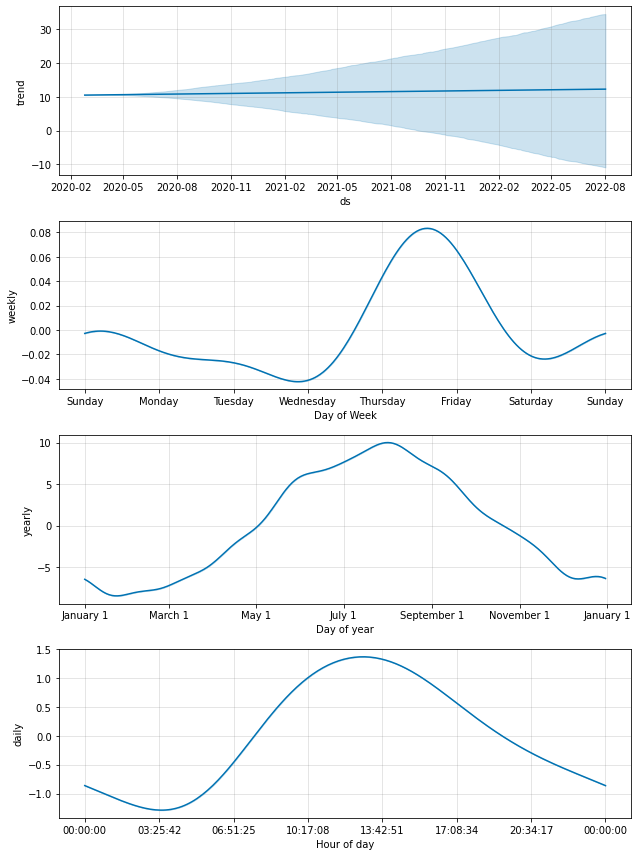

In [59]:
# Plot components that make up the additive regression function.
fsct_components = m.plot_components(forecast)

### 3. Evaluation

In [71]:
# Dataframe for our actual/predicted values and residuals.
pred = pd.DataFrame(dict(ds=test["ds"], y=test["y"].values, yhat=forecast["yhat"].values, resid=(test["y"].values - forecast["yhat"].values)))

In [72]:
pred

,ds,y,yhat,resid
87022,2020-02-25 00:00:00,4,2.087614,1.912386
87023,2020-02-25 01:00:00,4,1.931757,2.068243
87024,2020-02-25 02:00:00,3,1.784910,1.215090
87025,2020-02-25 03:00:00,4,1.684018,2.315982
87026,2020-02-25 04:00:00,3,1.683131,1.316869
...,...,...,...,...
108214,2022-08-01 02:00:00,16,21.088114,-5.088114
108215,2022-08-01 03:00:00,16,20.984804,-4.984804
108216,2022-08-01 04:00:00,16,20.981610,-4.981610
108217,2022-08-01 05:00:00,17,21.125689,-4.125689


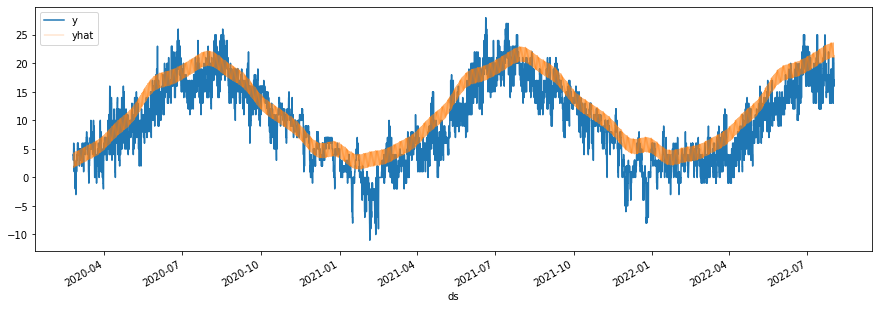

In [73]:
# Figure and axis-object.
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual and predicted values.
pred.plot(x="ds", y="y", ax=ax)
pred.plot(x="ds", y="yhat", linewidth=0.3, ax=ax)

# Show plot.
plt.show()

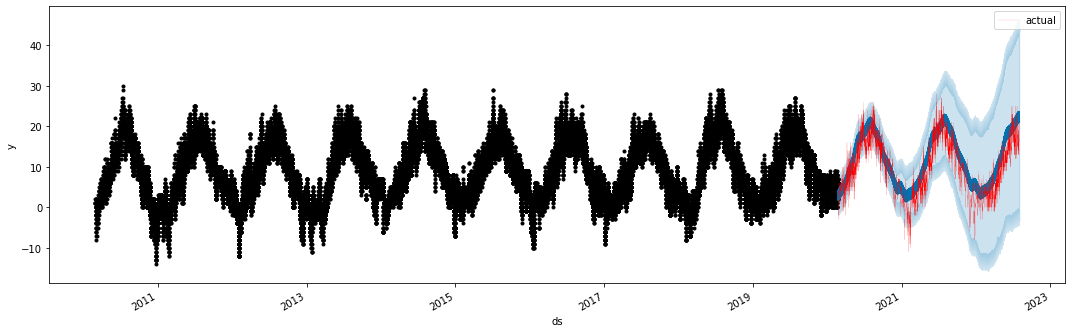

In [ ]:
# Figure and axis-object.
fig, ax = plt.subplots(figsize=(15, 5))

# Cast over our test data onto the models predictions.
m.plot(forecast, ax=ax)
test.plot(x="ds", y="y", label="actual", color="red", linewidth=0.1, ax=ax)

# Show plot.
plt.show()

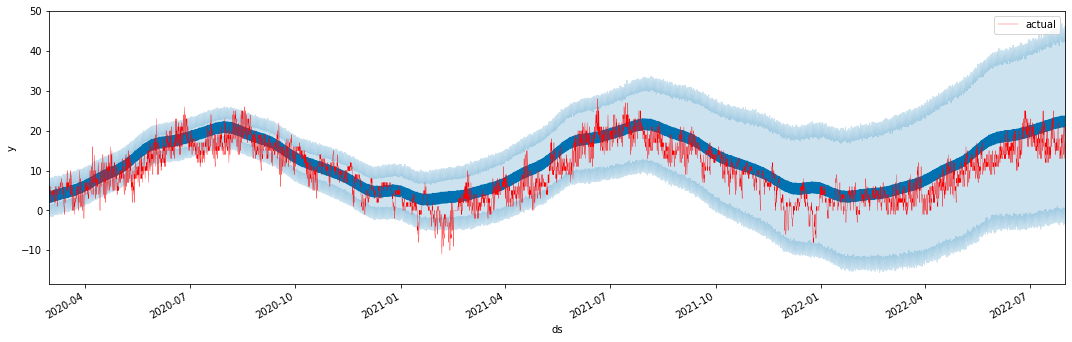

In [76]:
# Figure and axis-object.
fig, ax = plt.subplots(figsize=(15, 5))

# Cast over our test data onto the models predictions.
m.plot(forecast, ax=ax)
test.plot(x="ds", y="y", label="actual", color="red", linewidth=0.3, ax=ax)

# Zoom in on forecast.
ax.set_xlim("2020-03", "2022-08")

# Show plot.
plt.show()

### Resid plot
Shows whether or not the residuals go positive or negative as the fitted values change.

[Text(0, 0.5, 'Residuals'), Text(0.5, 0, 'Fitted values')]

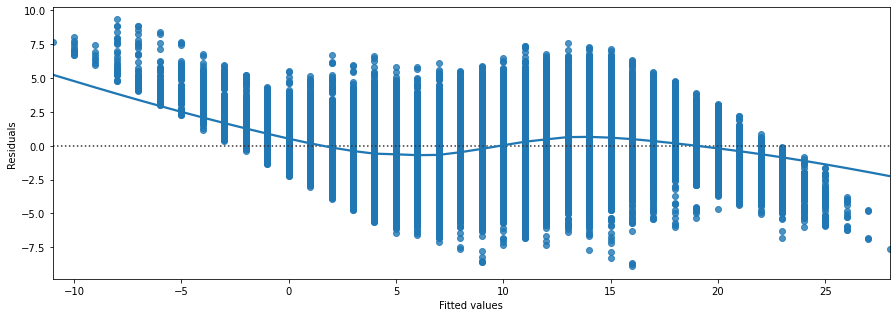

In [99]:
# Figure and axis-object.
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the residuals vs. fitted values
sns.residplot(x="y", y="yhat", data=pred, lowess=True, ax=ax)
ax.set(xlabel="Fitted values", ylabel="Residuals")

# Show plot.
plt.show()

- **Lowess** is a smooth curve following the data (trend)
- If residuals met the assumtion that they are normaly distributed, with mean zero, than the trend line should closely follow the `y = 0` line in the plot.

#### QQ-plot
It shows whether or not the residuals follow a normal distribution. 
- On the x-axis the points are quantiles from the normal distribution.
- On the y-axis you get the sample quantiles which are quantiles derived from your data set.

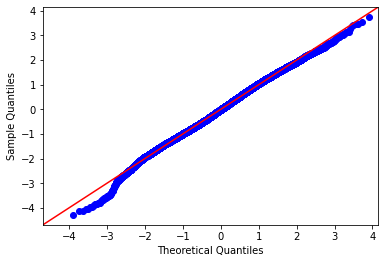

In [98]:
# Create the Q-Q plot of the residuals
qqplot(data=pred["resid"], fit=True, line="45");

**If the points track along the straight line, then they are normaly distributed, if they not then they aren't.**

In [ ]:
# MSE.
mean_squared_error(pred.y, pred.yhat)

12.658488465297626

In [83]:
# RMSE.
np.sqrt(mean_squared_error(pred.y, pred.yhat))

3.5578769603933225